#### 1. **Model Runner Step Sync And Async Testing**

Notebook tests `ModelRunnerStep` within a serving graph to enable real-time monitoring and drift detection with MLRun. 
The main focus is to test te preformance of sync and async usage.

In [1]:
# Import mlrun and create project instance
import mlrun

image = "mlrun/mlrun"
project_name = "monitored-model-runner-naive"
project = mlrun.get_or_create_project(project_name, context="./",user_project=True, allow_cross_project=True)

> 2025-10-27 14:16:13,488 [info] Project loaded successfully: {"project_name":"monitored-model-runner-naive-matanz"}


In [2]:
# Import tools
import pandas as pd
from sklearn.svm import SVC
import pickle
from sklearn.datasets import load_iris
from mlrun.features import Feature

In [3]:
# Train simple SVM model on Iris dataset, save it and reformat the DS as list
iris = load_iris()
clf = SVC()           
clf.fit(iris.data, iris.target)
with open("SVM.pkl", "wb") as fh:
    pickle.dump(clf, fh)
iris_data = iris["data"].tolist()

# load the dataset again as a DF
iris = load_iris()
train_set = pd.DataFrame(
    iris["data"],
    columns=["sepal_length_cm", "sepal_width_cm", "petal_length_cm", "petal_width_cm"],
)

# Create a Model Artifact in the project using the trained model
model_name = "SVM"
model_artifact = project.log_model(
    model_name,
    model_file="SVM.pkl",
    training_set=train_set,
    framework="sklearn",
    outputs=[Feature(name="label")],
)

#### 5. Define your function and ModelRunnerStep

Define functions to all the edge cases

In [4]:
# Config the code path and the serving function sync and async
sync_code_path = r"model_class_sync.py"
bouth_code_path = r"model_class_bouth.py"

async_sync_function = project.set_function(func=sync_code_path,image="mlrun/mlrun",kind="serving",name="async")
bouth_function = project.set_function(func=bouth_code_path,image="mlrun/mlrun",kind="serving",name="bouth")

In [5]:
from mlrun.serving.states import ModelRunnerStep

model_runner_step = ModelRunnerStep(
    name="my_runner", model_selector="MyModelSelector",model_selector_parameters={"name":"my-selector"})

for i in range(100):
    model_runner_step.add_model(
        model_class="MyModel",
        endpoint_name=f"my-{i}-model",
        model_artifact=model_artifact,
        input_path="inputs.here",
        result_path="outputs",
        outputs=["label"],
        execution_mechanism="naive",
    )

#### 6. Build graphs to all the edge cases

description


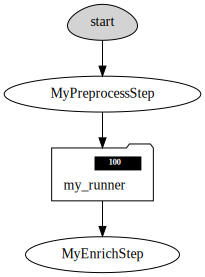

In [6]:
async_graph_defined = bouth_function.set_topology("flow",engine="async")
async_graph_defined.to("MyPreprocessStep").to(model_runner_step).to("MyEnrichStep").respond()
async_graph_defined.plot()

async_graph_undefined = async_sync_function.set_topology("flow",engine="async")
async_graph_undefined.to("MyPreprocessStep").to(model_runner_step).to("MyEnrichStep").respond()
async_graph_undefined.plot()


#### Run using mock

descteption

In [8]:
# 4. create mock server and test it locally (no k8s / deployment)

async_undefined_mock_server = bouth_function.to_mock_server()
async_defined_mock_server = async_sync_function.to_mock_server()

> 2025-10-27 14:28:16,351 [info] Server graph after adding system steps: {"graph":"{'MyPreprocessStep': {'class_name': 'MyPreprocessStep', 'kind': 'task'}, 'my_runner': {'class_name': 'mlrun.serving.ModelRunner', 'raise_exception': True, 'kind': 'model_runner', 'after': ['MyPreprocessStep'], 'endpoint_type': 1, 'model_endpoint_creation_strategy': 'skip', 'class_args': {'model_selector': ('MyModelSelector', {'name': 'my-selector'}), execution_mechanism_by_model_name: {'my-0-model': 'naive', 'my-1-model': 'naive', 'my-2-model': 'naive', 'my-3-model': 'naive', 'my-4-model': 'naive', 'my-5-model': 'naive', 'my-6-model': 'naive', 'my-7-model': 'naive', 'my-8-model': 'naive', 'my-9-model': 'naive', 'my-10-model': 'naive', 'my-11-model': 'naive', 'my-12-model': 'naive', 'my-13-model': 'naive', 'my-14-model': 'naive', 'my-15-model': 'naive', 'my-16-model': 'naive', 'my-17-model': 'naive', 'my-18-model': 'naive', 'my-19-model': 'naive', 'my-20-model': 'naive', 'my-21-model': 'naive', 'my-22-mod

In [9]:
async_undefined_mock_server
async_defined_mock_server


In [10]:
from random import choice
from datetime import datetime

iris_data = iris["data"].tolist()
data_point = choice(iris_data)
print(f"Data point:{data_point}")

time_before = datetime.now()
print("Before async_sync_function invoke:", time_before.strftime("%H:%M:%S.%f"))
async_sync_response = async_undefined_mock_server.test(
    "/",
    body={
        "models": None,
        "inputs": [data_point, data_point],
    },
)
time_after = datetime.now()
print("After invoke:", time_after.strftime("%H:%M:%S.%f"))

# Compute total time difference
total_time = time_after - time_before
print("Total time:", total_time.total_seconds(), "seconds")

Data point:[7.7, 3.8, 6.7, 2.2]
Before async_sync_function invoke: 14:28:28.628373
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
After invoke: 14:30:08.784521
Total time: 100.156148 seconds


In [ ]:
async_sync_response

In [26]:
iris_data = iris["data"].tolist()
data_point = choice(iris_data)
print(f"Data point:{data_point}")


print("Before async_sync_function invoke:", datetime.now().strftime("%H:%M:%S.%f"))
async_sync_response = async_defined_mock_server.test(
    "/",
    body={
        "models": None,
        "inputs": [data_point, data_point],
    },
)
print("After invoke:", datetime.now().strftime("%H:%M:%S.%f"))


Data point:[6.1, 3.0, 4.6, 1.4]
Before async_sync_function invoke: 15:22:49.559377
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
sync
After invoke: 15:24:29.710693


In [14]:
async_sync_response

{'my-0-model': {'outputs': {'label': [2, 2]}},
 'my-1-model': {'outputs': {'label': [2, 2]}},
 'my-2-model': {'outputs': {'label': [2, 2]}},
 'my-3-model': {'outputs': {'label': [2, 2]}},
 'my-4-model': {'outputs': {'label': [2, 2]}},
 'my-5-model': {'outputs': {'label': [2, 2]}},
 'my-6-model': {'outputs': {'label': [2, 2]}},
 'my-7-model': {'outputs': {'label': [2, 2]}},
 'my-8-model': {'outputs': {'label': [2, 2]}},
 'my-9-model': {'outputs': {'label': [2, 2]}},
 'my-10-model': {'outputs': {'label': [2, 2]}},
 'my-11-model': {'outputs': {'label': [2, 2]}},
 'my-12-model': {'outputs': {'label': [2, 2]}},
 'my-13-model': {'outputs': {'label': [2, 2]}},
 'my-14-model': {'outputs': {'label': [2, 2]}},
 'my-15-model': {'outputs': {'label': [2, 2]}},
 'my-16-model': {'outputs': {'label': [2, 2]}},
 'my-17-model': {'outputs': {'label': [2, 2]}},
 'my-18-model': {'outputs': {'label': [2, 2]}},
 'my-19-model': {'outputs': {'label': [2, 2]}},
 'my-20-model': {'outputs': {'label': [2, 2]}},
 '

#### 7. Deploying Your Function

Running this cell will deploy your serving function to the cluster. This also deploys the real-time monitoring functions for your project, which are configured to track the serving function's performance and detect model drift.

In [20]:
async_sync_function.deploy()
bouth_function.deploy()

> 2025-10-27 14:37:09,658 [info] Starting remote function deploy
2025-10-27 14:37:10  (info) Deploying function
2025-10-27 14:37:10  (info) Building
2025-10-27 14:37:10  (info) Staging files and preparing base images
2025-10-27 14:37:10  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2025-10-27 14:37:10  (info) Building processor image
2025-10-27 14:38:16  (info) Build complete
2025-10-27 14:38:25  (info) Function deploy complete
> 2025-10-27 14:38:30,947 [info] Model endpoint creation task completed with state succeeded
> 2025-10-27 14:38:30,947 [info] Successfully deployed function: {"external_invocation_urls":["monitored-model-runner-naive-matanz-async.default-tenant.app.cust-cs-il.iguazio-cd0.com/"],"internal_invocation_urls":["nuclio-monitored-model-runner-naive-matanz-async.default-tenant.svc.cluster.local:8080"]}
> 2025-10-27 14:38:31,022 [info] Starting remote function deploy
2025-10-27 14:38:31  (info) Deploying function
2025-1

'http://monitored-model-runner-naive-matanz-bouth.default-tenant.app.cust-cs-il.iguazio-cd0.com/'

In [21]:
iris_data = iris["data"].tolist()
data_point = choice(iris_data)
print(f"Data point:{data_point}")


time_before = datetime.now()
print("Before async_sync_function invoke:", time_before.strftime("%H:%M:%S.%f"))
async_sync_response = async_sync_function.invoke(
    "/",
    body={
        "models": None,
        "inputs": [data_point, data_point],
    },
)
time_after = datetime.now()
print("After invoke:", time_after.strftime("%H:%M:%S.%f"))

# Compute total time difference
total_time = time_after - time_before
print("Total time:", total_time.total_seconds(), "seconds")

Data point:[7.7, 3.0, 6.1, 2.3]
Before async_sync_function invoke: 14:39:52.332380
After invoke: 14:41:32.557720
Total time: 100.22534 seconds


In [22]:
async_sync_response

{'my-0-model': {'outputs': {'label': [2, 2]}},
 'my-1-model': {'outputs': {'label': [2, 2]}},
 'my-2-model': {'outputs': {'label': [2, 2]}},
 'my-3-model': {'outputs': {'label': [2, 2]}},
 'my-4-model': {'outputs': {'label': [2, 2]}},
 'my-5-model': {'outputs': {'label': [2, 2]}},
 'my-6-model': {'outputs': {'label': [2, 2]}},
 'my-7-model': {'outputs': {'label': [2, 2]}},
 'my-8-model': {'outputs': {'label': [2, 2]}},
 'my-9-model': {'outputs': {'label': [2, 2]}},
 'my-10-model': {'outputs': {'label': [2, 2]}},
 'my-11-model': {'outputs': {'label': [2, 2]}},
 'my-12-model': {'outputs': {'label': [2, 2]}},
 'my-13-model': {'outputs': {'label': [2, 2]}},
 'my-14-model': {'outputs': {'label': [2, 2]}},
 'my-15-model': {'outputs': {'label': [2, 2]}},
 'my-16-model': {'outputs': {'label': [2, 2]}},
 'my-17-model': {'outputs': {'label': [2, 2]}},
 'my-18-model': {'outputs': {'label': [2, 2]}},
 'my-19-model': {'outputs': {'label': [2, 2]}},
 'my-20-model': {'outputs': {'label': [2, 2]}},
 '

In [23]:
iris_data = iris["data"].tolist()
data_point = choice(iris_data)
print(f"Data point:{data_point}")


print("Before bouth_function invoke:", datetime.now().strftime("%H:%M:%S.%f"))
bouth_response = bouth_function.invoke(
    "/",
    body={
        "models": None,
        "inputs": [data_point, data_point],
    },
)
print("After invoke:", time_after.strftime("%H:%M:%S.%f"))

# Compute total time difference
total_time = time_after - time_before
print("Total time:", total_time.total_seconds(), "seconds")

Data point:[5.5, 4.2, 1.4, 0.2]
Before bouth_function invoke: 14:41:32.665912
After invoke: 14:41:32.557720
Total time: 100.22534 seconds


In [24]:
bouth_response

{'my-0-model': {'outputs': {'label': [0, 0]}},
 'my-1-model': {'outputs': {'label': [0, 0]}},
 'my-2-model': {'outputs': {'label': [0, 0]}},
 'my-3-model': {'outputs': {'label': [0, 0]}},
 'my-4-model': {'outputs': {'label': [0, 0]}},
 'my-5-model': {'outputs': {'label': [0, 0]}},
 'my-6-model': {'outputs': {'label': [0, 0]}},
 'my-7-model': {'outputs': {'label': [0, 0]}},
 'my-8-model': {'outputs': {'label': [0, 0]}},
 'my-9-model': {'outputs': {'label': [0, 0]}},
 'my-10-model': {'outputs': {'label': [0, 0]}},
 'my-11-model': {'outputs': {'label': [0, 0]}},
 'my-12-model': {'outputs': {'label': [0, 0]}},
 'my-13-model': {'outputs': {'label': [0, 0]}},
 'my-14-model': {'outputs': {'label': [0, 0]}},
 'my-15-model': {'outputs': {'label': [0, 0]}},
 'my-16-model': {'outputs': {'label': [0, 0]}},
 'my-17-model': {'outputs': {'label': [0, 0]}},
 'my-18-model': {'outputs': {'label': [0, 0]}},
 'my-19-model': {'outputs': {'label': [0, 0]}},
 'my-20-model': {'outputs': {'label': [0, 0]}},
 '

In [25]:
from random import choice

iris_data = iris["data"].tolist()
data_point = choice(iris_data)
print(f"Data point:{data_point}")
response = function.invoke(
    "/", body={"models": ['my-13-model','my-16-model'], "inputs": [data_point, data_point]}
)

Data point:[5.5, 2.6, 4.4, 1.2]


NameError: name 'function' is not defined

In [ ]:
response

# TODO
2. Check if we get a warning when we try to run async when there is no "async predict" 
    
3. Check if the async work as expected

4. Try to add different prompts to the same model using async, and inspect the behavior
